In [1]:
#cells will fill entire width of the browser
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

#Tells Jupyter to reload custom classes from scratch everytime an import cell is run, if you edit a custom class
#between imports Jupyter would otherwise need to be restarted completely. Buyer beware: old class objects in the 
#current namespace will cause errors at execution
%load_ext autoreload
%autoreload 2

#switches matplotlib to show plots in the browser rather than opening a new window
%matplotlib inline

#always forget to do this for better looking plots
import seaborn
seaborn.set()

In [4]:
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
from cvxpy import *
from statsmodels.tsa import stattools
from sklearn import preprocessing
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import random
import copy
import scipy
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim

#energyplus processing functions
from eplusprocessing import *
from buildsys_funcs import *

/home/chase/applications/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [5]:
#check that sklearn's OLS solution is similar to gradient descent for parameterization

#use the classification rule on simulations that have been transfered via WLS
#for each sample size, sweep weight hyper parameter space, report best weight for sample size
#report F1 for each sample size of transfered matrix vs a matrix learned from new data only

In [6]:
#features to ignore"
ignore = ["Performance Curve Input Variable 1 Value [] !Each Call", "Performance Curve Output Value [] !Each Call"]

#def parse_line()

def read_data_dictionary(lines):
    data_dict = {}
    for line in lines:
        l = line.strip()
        if l == "End of Data Dictionary":
            break
        else:
            tokens = l.split(",")
            if int(tokens[0]) == 2:
                data_dict[int(tokens[0])] = tokens[1:]
                #parse time dictionary line
            elif int(tokens[0]) > 6 and int(tokens[1]) == 1:
                if tokens[-1] in ignore:
                    pass
                elif len(tokens) == 4:
                    data_dict[int(tokens[0])] = tokens[-2] + tokens[-1]
                    
                else:
                    #parse value dictionary line
                    data_dict[int(tokens[0])] = tokens[-1]
            else:
                pass
    return(data_dict)

def parse_time_line(line_str):
    #2,8,Day of Simulation[],Month[],Day of Month[],DST Indicator[1=yes 0=no],Hour[],StartMinute[],EndMinute[],DayType
    #2, 1, 1, 1, 0, 1, 0.00, 2.00, Holiday
    #only want hourly times, multiple minute 2's, assuming got correct
    tokens = line_str.strip().split(",")
    minute=float(tokens[-3])
    hour=int(tokens[-4])
    day=int(tokens[-6])
    month=int(tokens[-7])
    return(datetime.datetime(2017, month, day, hour-1, 0, 0)) #2017 so that the 1st is a Sunday + not leapyear
    #return(str(month) + "/" + str(day) + " " + str(hour) + ":00")
     
def parse_lines(lines, feature_inds):
    data_values = {}
    data_values[2] = []
    for i in feature_inds:
        data_values[i] = []
    
    start_i = lines.index("End of Data Dictionary\n")
    for line in lines[start_i+1:-2]:
        tokens = line.strip().split(",")
        if int(tokens[0]) == 2:
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                data_values[2].append(t)
        elif int(tokens[0]) in feature_inds:
            data_values[int(tokens[0])].append(float(tokens[-1]))
        else:
            pass
    return(data_values)
    #return hourly list for all feature vars, plus hourly list with times to check sorting
    
def get_holidays(lines):
    holidays = []
    weekends = []
    all_dates = []
    
    start_i = lines.index("End of Data Dictionary\n")
    for line in lines[start_i+1:-2]:
        tokens = line.strip().split(",")
        if tokens[-1] == "Holiday":
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                holidays.append(t)
        elif int(tokens[0]) == 2:
            if float(tokens[-3]) == 0.00 and float(tokens[-2]) == 60.00:
                t = parse_time_line(line)
                all_dates.append(t)
                if t.weekday() == 6 or t.weekday() == 0:
                    weekends.append(t)
    return(all_dates, weekends, holidays)
                      
def norm_array(arr):
    return(preprocessing.minmax_scale(arr, axis=1))

def read_total_data_array(filepath, dep_var_names, ind_var_names, zone_temp_inds, first_diff=False, no_weekend_holiday=False):
    with open(datapath + filepath) as d:
        lines = d.readlines()
        lines.pop(0)
        data_dict = read_data_dictionary(lines)
        data = parse_lines(lines, data_dict)
        all_dates, weekends, holidays = get_holidays(lines)
        ind_map = {}
        for key, value in data_dict.items():
            if type(value) == list:
                value = value[-1]
            ind_map[value] = key

    X = np.zeros((len(dep_var_names) + len(zone_temp_inds), 8760))
    U = np.zeros((len(ind_var_names), 8760))

    for i in range(len(ind_var_names)):
        item = ind_var_names[i]
        ind = ind_map[item]
        if item == 'DayType':
            lis = data[ind]
            out = []
            for val in lis:
                out.append(val.weekday())
            arr = np.array(out)
        else:
            arr = np.array(data[ind])
        U[i,:] = arr

    for j in range(len(dep_var_names)):
        item = dep_var_names[j]
        ind = ind_map[item]
        arr = np.array(data[ind])
        X[j,:] = arr

    for j in range(len(zone_temp_inds)):
        ind = zone_temp_inds[j]
        arr = np.array(data[ind])
        X[j+len(dep_var_names),:] = arr
        
    if no_weekend_holiday == True:
        weekend_i = []
        holiday_i = []
        for j in range(len(all_dates)):
            if all_dates[j] in weekends:
                weekend_i.append(j)
            if all_dates[j] in holidays:
                holiday_i.append(j)
                
        del_i = np.array(list(set(holiday_i + weekend_i)))
        X = np.delete(X, del_i, axis=1)
        U = np.delete(U, del_i, axis=1)
    
    if first_diff == True:
        X = np.diff(X, n=1, axis=1)
        U = np.diff(U, n=1, axis=1)

    Z = np.vstack((X, U))

    return(Z, X, U)

def minibatch_X_Y_arrays(X_arr, Y_arr, batchsize):    
    #list of training, target pair tuples
    remainder = X_arr.shape[1] % batchsize
    diff = batchsize - remainder
    tail_X = X_arr[:,-diff:] 
    tail_Y = Y_arr[:,-diff:]
    out_X = [ X_arr[:,i*batchsize:(i+1)*batchsize] for i in range(int(float(X_arr.shape[1])/float(batchsize))) ]
    out_Y = [ Y_arr[:,i*batchsize:(i+1)*batchsize] for i in range(int(float(Y_arr.shape[1])/float(batchsize)))]
    out_X = out_X + [tail_X]
    out_Y = out_Y + [tail_Y]
    return(out_X, out_Y)

def split_train_val(Z, X, U, order=1, shuff=True, split_prop=0.8):
    all_pairs = []
    for i in range(Z.shape[1] - order):  #not 8760 for first-diff
        all_pairs.append((Z[:,i:i+order-1].flatten(), Z[0:-U.shape[0],i+order]))

    if shuff == True:
        random.shuffle(all_pairs) 
    else:
        pass

    train_pairs = all_pairs[0:int(split_prop*len(all_pairs))]
    val_pairs = all_pairs[-int((1.0-split_prop)*len(all_pairs)):]
    
    #normalize to training data
    X_train = []
    Y_train = []

    for item in train_pairs:
        X_train.append(item[0])
        Y_train.append(item[1])

    X_val = []
    Y_val = []
    for item in val_pairs:
        X_val.append(item[0])
        Y_val.append(item[1])

    X_train = np.asarray(X_train).T
    Y_train = np.asarray(Y_train).T

    X_val = np.asarray(X_val).T
    Y_val = np.asarray(Y_val).T
    
    return(X_train, Y_train, X_val, Y_val)

def normalize_data_set(X, Y, X_minmax_vals):
    X_norm = copy.copy(X)
    Y_norm = copy.copy(Y)
    
    for row in range(X.shape[0]):
        mx = np.max(X_minmax_vals[row,:])
        mn = np.min(X_minmax_vals[row,:])

        X_norm[row,:] = (1.0/(mx - mn))*(X[row,:] - mn)

        if row < Y.shape[0]:
            Y_norm[row,:] = (1.0/(mx - mn))*(Y[row,:] - mn)
            
    return(X_norm, Y_norm)

def polynomial_kernel_mat(X, poly_degree):
    out = X
    for d in range(2,poly_degree+1):
        out = np.vstack((out, np.power(X, d)))
    return(out)

In [7]:
#global vars
datapath = "/home/chase/projects/building_transfer/data/eplus_sims/"

#shared simulation var names
dep_var_names = ['Electricity:Facility [J] !Hourly', 'Fans:Electricity [J] !Hourly', 'Cooling:Electricity [J] !Hourly']
ind_var_names = ['EnvironmentSite Outdoor Air Drybulb Temperature [C] !Hourly', 'EnvironmentSite Outdoor Air Relative Humidity [%] !Hourly', 'DayType']

poly_degree = 5
order = 26 #26

In [8]:
#building specific var names

zone_temp_inds = [863,864,865]

Z, X, U = read_total_data_array("refbuild_med/seattle/RefBldgMediumOfficeNew2004_Chicago.eso", dep_var_names, ind_var_names, zone_temp_inds, first_diff=True, no_weekend_holiday=True)

In [9]:
X_train_pre, Y_train_pre, X_val_pre, Y_val_pre = split_train_val(Z, X, U, order=order, shuff=False, split_prop=0.8)
X_train, Y_train = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)
X_val, Y_val = normalize_data_set(X_train_pre, Y_train_pre, X_train_pre)

#kernelize
X_train_poly = polynomial_kernel_mat(X_train, poly_degree)
X_val_poly = polynomial_kernel_mat(X_val, poly_degree)

#mean shift
m = False
if m == True:
    mean_feature = np.mean(X_train_poly, axis=1)
    mean_array = np.asarray([ mean_feature for i in range(X_train_poly.shape[1]) ]).T
    X_train_poly = X_train_poly - mean_array

    mean_array_v = np.asarray([ mean_feature for i in range(X_val_poly.shape[1]) ]).T
    X_val_poly = X_val_poly - mean_array_v

    mean_output = np.mean(Y_train, axis=1)
    mean_array = np.asarray([ mean_output for i in range(Y_train.shape[1]) ]).T
    Y_train = Y_train - mean_array

    mean_array_v = np.asarray([ mean_output for i in range(Y_val.shape[1]) ]).T
    Y_val = Y_val - mean_array_v

#shuffle
shuff = np.arange(X_train.shape[1])
np.random.shuffle(shuff)

X_train_shuff = copy.copy(X_train_poly)[:,shuff]
Y_train_shuff = copy.copy(Y_train)[:,shuff]

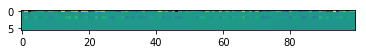

In [10]:
#sklearn solution


reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(X_train_shuff.T, Y_train_shuff.T)

plt.imshow(reg.coef_[:,-100:])
plt.show()

In [11]:
#the MSE using OLS
mean_squared_error(Y_val.T, reg.coef_.dot(X_val_poly).T, multioutput='uniform_average')

0.00010194455217769091

In [12]:
### Per season basis, same building, Medium office

In [13]:
X_all_pre, Y_all_pre, X_v, Y_v = split_train_val(Z, X, U, order=order, shuff=False, split_prop=1.0)
X_all, Y_all = normalize_data_set(X_all_pre, Y_all_pre, X_all_pre)

#kernelize
X_all_poly = polynomial_kernel_mat(X_all, poly_degree)

In [14]:
shift=168  #just to get it away from the extreme ends of the seasons
horizon=168*2
season_i = [0+shift, 1595+shift, 2*1595+shift, 3*1595+shift]
val_out = {}
for seas in season_i:
    val_out[seas] = {}
    val_out[seas]["validation_loss"] = []
    val_out[seas]["validation_mape"] = []
    val_out[seas]["avg_training_losses"] = []
    num_hours = []

    for s in range(25,horizon):
        num_hours.append(s + order)
        if s % 10 == 0:
            print("Training data size: ", s)

        X_train_s = X_all_poly[:,seas:seas+s]
        Y_train_s = Y_all[:,seas:seas+s]

        reg = linear_model.LinearRegression(fit_intercept=False)
        reg.fit(X_train_s.T, Y_train_s.T)
        
        train_loss = mean_squared_error(Y_train_s.T, reg.coef_.dot(X_train_s).T, multioutput='uniform_average')
        
        val_out[seas]["avg_training_losses"].append(train_loss)

        others = copy.copy(season_i)
        others.remove(seas)
        all_val = []
        for si in others:
            all_val.append(np.arange(si-shift,si+1594-shift,1)) #validate with all other seasons
        all_val_inds = np.asarray(all_val).flatten()
        #print(all_val_inds)
        X_val_s = X_all_poly[:,all_val_inds]
        Y_val_s = Y_all[:,all_val_inds]
        
        val_loss = mean_squared_error(Y_val_s.T, reg.coef_.dot(X_val_s).T, multioutput='uniform_average')
        
        val_out[seas]["validation_loss"].append(val_loss)
        val_out[seas]["validation_mape"].append(np.mean(np.abs(reg.coef_.dot(X_val_s).T - Y_val_s.T)/Y_val_s.T))

Training data size:  30
Training data size:  40
Training data size:  50
Training data size:  60
Training data size:  70
Training data size:  80
Training data size:  90
Training data size:  100
Training data size:  110
Training data size:  120
Training data size:  130
Training data size:  140
Training data size:  150
Training data size:  160
Training data size:  170
Training data size:  180
Training data size:  190
Training data size:  200
Training data size:  210
Training data size:  220
Training data size:  230
Training data size:  240
Training data size:  250
Training data size:  260
Training data size:  270
Training data size:  280
Training data size:  290
Training data size:  300
Training data size:  310
Training data size:  320
Training data size:  330
Training data size:  30
Training data size:  40
Training data size:  50
Training data size:  60
Training data size:  70
Training data size:  80
Training data size:  90
Training data size:  100
Training data size:  110
Training data 

KeyboardInterrupt: 

In [ ]:
plt.plot(num_hours, np.asarray(val_out[0+shift]["avg_training_losses"]), label="Winter")
plt.plot(num_hours, np.asarray(val_out[1595+shift]["avg_training_losses"]), label="Spring")
plt.plot(num_hours, np.asarray(val_out[2*1595+shift]["avg_training_losses"]), label="Summer")
plt.plot(num_hours, np.asarray(val_out[3*1595+shift]["avg_training_losses"]), label="Fall")
plt.legend()
plt.title("Training MSE on all other seasons\n training on consecutive hours by season")
plt.xlabel("consecutive hours of training data")
plt.ylabel("MSE")
plt.show()

In [ ]:
plt.plot(num_hours, np.asarray(val_out[0+shift]["validation_loss"]), label="Winter")
plt.plot(num_hours, np.asarray(val_out[1595+shift]["validation_loss"]), label="Spring")
plt.plot(num_hours, np.asarray(val_out[2*1595+shift]["validation_loss"]), label="Summer")
plt.plot(num_hours, np.asarray(val_out[3*1595+shift]["validation_loss"]), label="Fall")
plt.legend()
plt.title("Validation MSE on all other seasons\n training on consecutive hours by season")
plt.xlabel("consecutive hours of training data")
plt.ylabel("MSE")
plt.show()

In [ ]:
plt.plot(np.asarray(val_out[0+shift]["validation_mape"]), label="Winter")
plt.plot(np.asarray(val_out[1595+shift]["validation_mape"]), label="Spring")
plt.plot(np.asarray(val_out[2*1595+shift]["validation_mape"]), label="Summer")
plt.plot(np.asarray(val_out[3*1595+shift]["validation_mape"]), label="Fall")
plt.legend()
plt.title("Validation MAPE on all other seasons\n training on consecutive hours by season")
plt.xlabel("consecutive hours of training data")
plt.ylabel("MAPE")
plt.show()

In [62]:
#train initial for 2 weeks in winter

shift=168
horizon = 50
start_i = 0+shift

#train the winter transition matrix
X_train_s = X_all_poly[:,0+shift:0+shift+horizon]
Y_train_s = Y_all[:,0+shift:0+shift+horizon]

reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(X_train_s.T, Y_train_s.T)

with open("winter_ols.skl", 'wb') as d:
    pickle.dump(reg, d)

#train_loss = mean_squared_error(Y_train_s.T, reg.coef_.dot(X_train_s).T, multioutput='uniform_average')

#hyperparameter sweep
weight_vals = [0, 1e-32, 1e-30, 1e-28, 1e-26, 1e-24, 1e-22, 1e-20, 1e-18, 1e-16, 1e-12, 1e-4, 1]
validation_loss_transfer = []
validation_mape_transfer = []

all_val_inds = np.arange(2*1594,3*1594,1)  #get all summer values
X_val_s = X_all_poly[:,all_val_inds]
Y_val_s = Y_all[:,all_val_inds]

for wv in weight_vals:
    #transfer with summer data

    validation_loss_transfer.append([])
    validation_mape_transfer.append([])

    num_hours = []

    for s in range(25,horizon):
        num_hours.append(s + order)
        if s % 10 == 0:
            print("Training data size: ", s)

        X_train_summer = X_all_poly[:,2*1594+shift:2*1594+shift+s]  #get summer training data
        Y_train_summer = Y_all[:,2*1594+shift:2*1594+shift+s]

        weights_winter = np.array([ wv for i in range(X_train_s.shape[1]) ]) #np.power(X_train_s.shape[1], 2)
        weights_summer = np.array([ 1 for i in range(X_train_summer.shape[1]) ])

        X_transfer = np.hstack((X_train_s, X_train_summer))
        Y_transfer = np.hstack((Y_train_s, Y_train_summer))
        weights = np.concatenate((weights_winter, weights_summer))

        reg = linear_model.LinearRegression(fit_intercept=False)
        reg.fit(X_transfer.T, Y_transfer.T, sample_weight=weights)

        val_loss = mean_squared_error(Y_val_s.T, reg.coef_.dot(X_val_s).T, multioutput='uniform_average')

        validation_loss_transfer[-1].append(val_loss)
        validation_mape_transfer[-1].append(np.mean(np.abs(reg.coef_.dot(X_val_s).T - Y_val_s.T)/Y_val_s.T))

Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40
Training data size:  30
Training data size:  40


In [63]:
#set "inital" as random, train and validate in summer
shift=168
horizon = 50
start_i = 0+shift

validation_loss_random = []
validation_mape_random = []


others = copy.copy(season_i)
others.remove(seas)
all_val = []
for si in others:
    all_val.append(np.arange(si-shift,si+1594-shift,1)) #validate with all other seasons
all_val_inds = np.asarray(all_val).flatten()
#print(all_val_inds)
X_val_s = X_all_poly[:,all_val_inds]
Y_val_s = Y_all[:,all_val_inds]

all_val_inds = np.arange(2*1594,3*1594,1)  #get all summer values
X_val_s = X_all_poly[:,all_val_inds]
Y_val_s = Y_all[:,all_val_inds]

for s in range(25,horizon):
    num_hours.append(s + order)
    if s % 10 == 0:
        print("Training data size: ", s)
        
    X_train_summer = X_all_poly[:,2*1594+shift:2*1594+shift+s]  #get summer training data
    Y_train_summer = Y_all[:,2*1594+shift:2*1594+shift+s]
    
    reg = linear_model.LinearRegression(fit_intercept=False)
    reg.fit(X_train_summer.T, Y_train_summer.T)
    
    val_loss = mean_squared_error(Y_val_s.T, reg.coef_.dot(X_val_s).T, multioutput='uniform_average')
        
    validation_loss_random.append(val_loss)
    validation_mape_random.append(np.mean(np.abs(reg.coef_.dot(X_val_s).T - Y_val_s.T)/Y_val_s.T))
    
    del(reg)

Training data size:  30
Training data size:  40


In [64]:
weight_index = 5

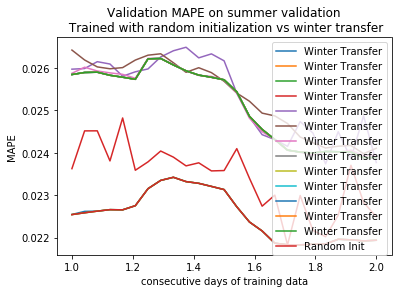

In [65]:
nh = np.asarray([float(i + 24) for i in range(len(validation_mape_transfer[weight_index]))])/24.0
for i in range(len(weight_vals)):
    weight_index = i
    plt.plot(nh, np.asarray(validation_mape_transfer[weight_index]), label="Winter Transfer")
plt.plot(nh, np.asarray(validation_mape_random), label="Random Init")
plt.legend()
plt.title("Validation MAPE on summer validation\n Trained with random initialization vs winter transfer")
plt.xlabel("consecutive days of training data")
plt.ylabel("MAPE")
plt.show()

In [68]:
for i in range(10):
    print(1*np.power(10.0, -i))

1.0
0.1
0.01
0.001
0.0001
1e-05
1e-06
1e-07
1e-08
1e-09


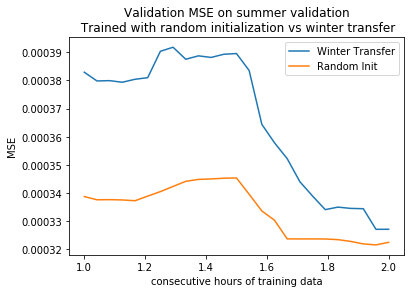

In [61]:
plt.plot(nh, np.asarray(validation_loss_transfer[weight_index]), label="Winter Transfer")
plt.plot(nh, np.asarray(validation_loss_random), label="Random Init")
plt.legend()
plt.title("Validation MSE on summer validation\n Trained with random initialization vs winter transfer")
plt.xlabel("consecutive hours of training data")
plt.ylabel("MSE")
plt.show()

In [ ]:
#sample weights don't seem to be working

#compare to just winter applied to summer data without transfer

(2, 20)

In [5]:
#weighted least squares is working, include more variables and transfer to different climate/building?

#does classification work better with the least squares trained matrix?